# Exploring Security Practices in Infrastructure as Code: An Empirical Study of AWS Terraform Configurations

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.dpi'] = 300

In [36]:
RESULTS_FILE = "./csv/results.csv"
POLICIES_FILE = "./csv/policies.csv"
DATASET = "./csv/dataset.csv"
METRICS_FILE = "./csv/dataset_repo_metadata.csv"

Retrieve the list of the 121 selected policies and their mapped categories.
We also print the policies list to use in the checkov_looper.py Python script.

In [37]:
categories = {}
policies = {}
p_names = {}
with open(POLICIES_FILE, 'r') as f:
    f.readline()
    policies_rows = f.readlines()
    for row in policies_rows:
        s_row = row.split(',')
        if s_row[5] == "TRUE":
            policy_id = s_row[1]
            policy_name = s_row[3]
            policy_description = s_row[4]
            policy_category = s_row[6].strip('\n')
            if policy_category == "":
                policy_category = "Uncategorized"

            policies[policy_id] = policy_description
            categories[policy_id] = policy_category
            p_names[policy_id] = policy_name

In [38]:
print("CHECK_LIST = " + ",".join(policies))

CHECK_LIST = CKV_AWS_1,CKV_AWS_2,CKV_AWS_3,CKV_AWS_5,CKV_AWS_6,CKV_AWS_8,CKV_AWS_16,CKV_AWS_17,CKV_AWS_18,CKV_AWS_19,CKV_AWS_20,CKV_AWS_22,CKV_AWS_24,CKV_AWS_25,CKV_AWS_26,CKV_AWS_27,CKV_AWS_29,CKV_AWS_30,CKV_AWS_31,CKV_AWS_32,CKV_AWS_33,CKV_AWS_34,CKV_AWS_35,CKV_AWS_38,CKV_AWS_39,CKV_AWS_40,CKV_AWS_41,CKV_AWS_42,CKV_AWS_43,CKV_AWS_44,CKV_AWS_45,CKV_AWS_46,CKV_AWS_47,CKV_AWS_48,CKV_AWS_49,CKV_AWS_50,CKV_AWS_53,CKV_AWS_54,CKV_AWS_55,CKV_AWS_56,CKV_AWS_57,CKV_AWS_58,CKV_AWS_59,CKV_AWS_60,CKV_AWS_61,CKV_AWS_62,CKV_AWS_63,CKV_AWS_64,CKV_AWS_67,CKV_AWS_68,CKV_AWS_69,CKV_AWS_71,CKV_AWS_72,CKV_AWS_73,CKV_AWS_76,CKV_AWS_77,CKV_AWS_79,CKV_AWS_83,CKV_AWS_84,CKV_AWS_87,CKV_AWS_88,CKV_AWS_91,CKV_AWS_92,CKV_AWS_94,CKV_AWS_96,CKV_AWS_97,CKV_AWS_98,CKV_AWS_99,CKV_AWS_100,CKV_AWS_101,CKV_AWS_102,CKV_AWS_103,CKV_AWS_105,CKV_AWS_106,CKV_AWS_107,CKV_AWS_108,CKV_AWS_110,CKV_AWS_111,CKV_AWS_112,CKV_AWS_113,CKV_AWS_117,CKV_AWS_118,CKV_AWS_119,CKV_AWS_126,CKV_AWS_130,CKV_AWS_131,CKV_AWS_136,CKV_AWS_140,CKV_A

## RQ1: Category Mapping Distribution

In [39]:
categories_count = {}
for policy in policies:
    categories_count[categories.get(policy, "Uncategorized")] = categories_count.get(categories.get(policy, "Uncategorized"), 0) + 1

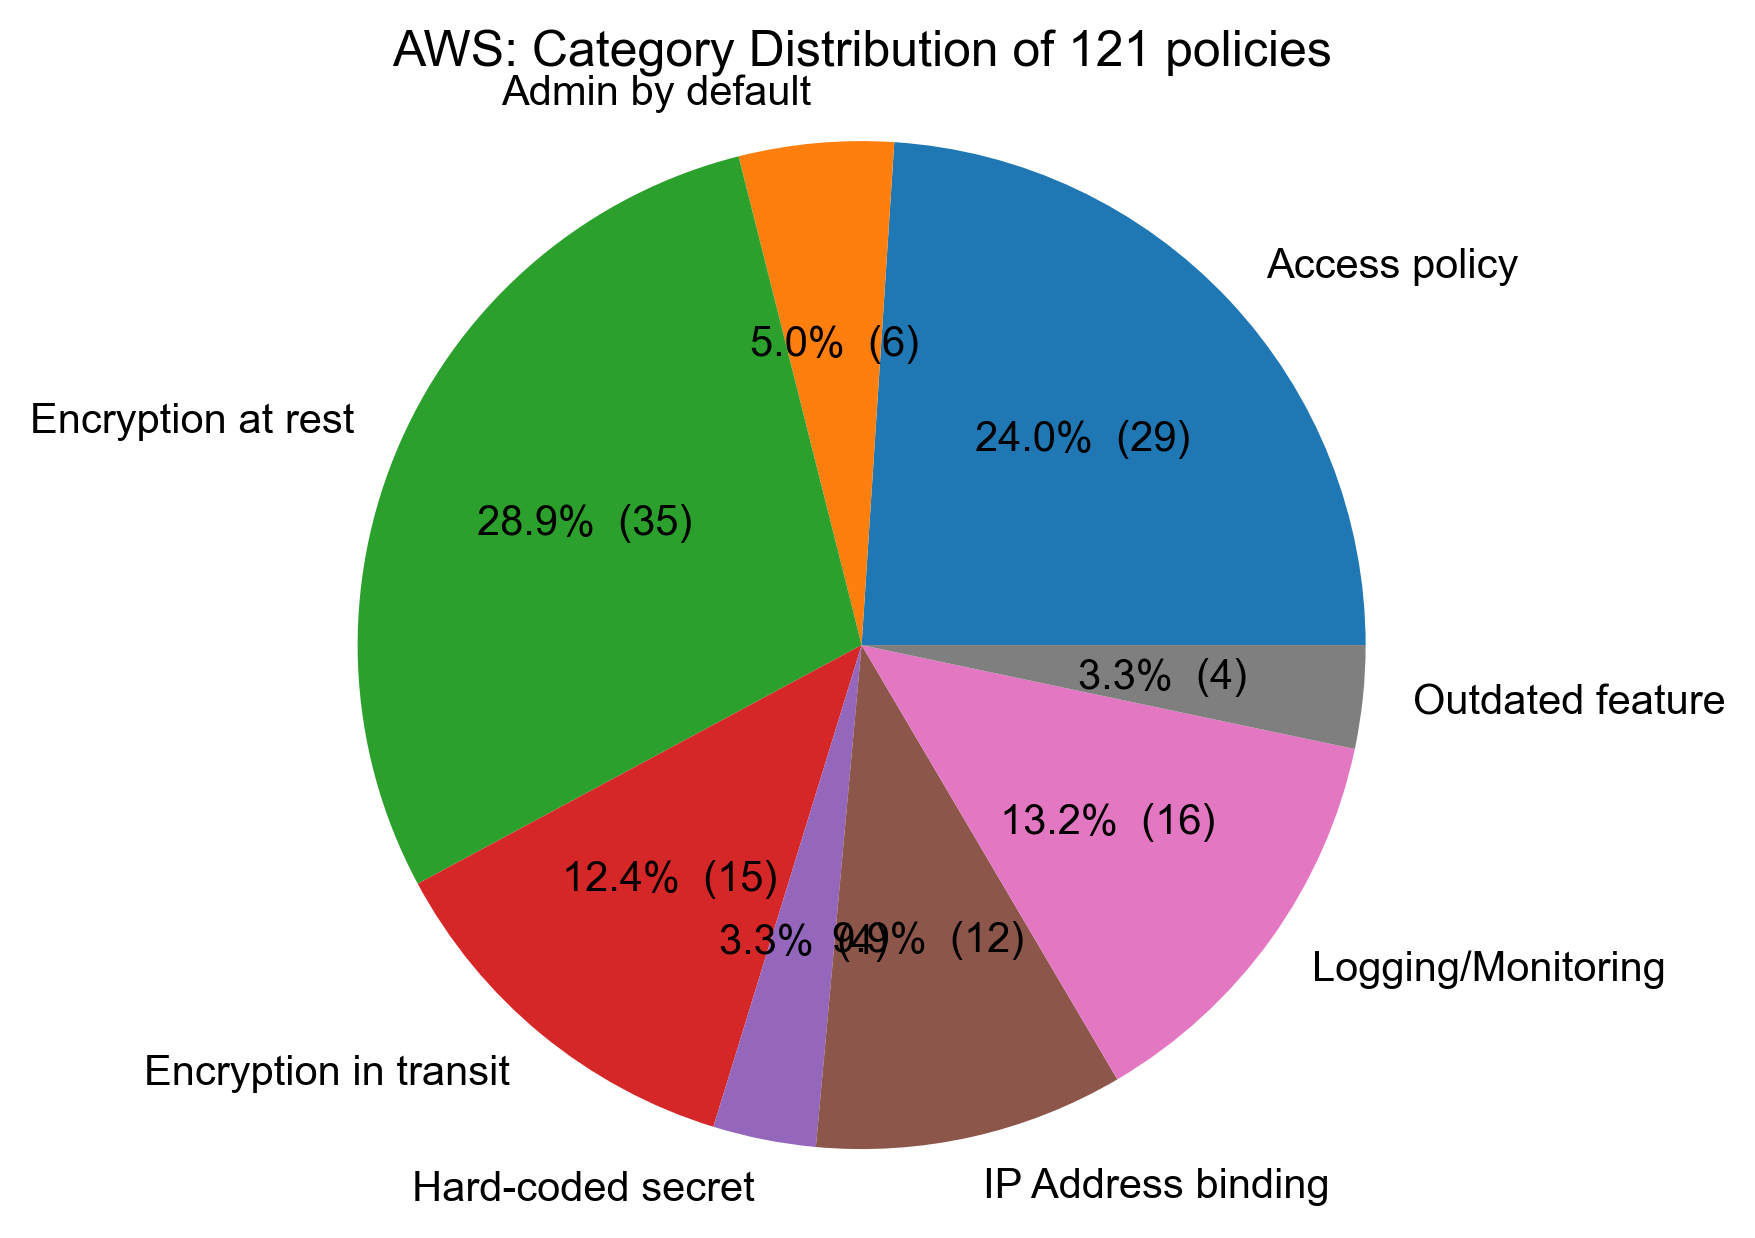

In [40]:
labels2 = sorted([*categories_count.keys()])
sizes2 = [categories_count[k] for k in labels2]
fig2, ax2 = plt.subplots()
ax2.pie(sizes2, labels=labels2, autopct=lambda p : '{:.1f}%  ({:,.0f})'.format(p,p * sum(sizes2)/100))
ax2.axis('equal')
ax2.set(title="AWS: Category Distribution of {} policies".format(len(policies)))
plt.show()

## Results analysis

Load the repository list of our dataset and the checkov results

In [41]:
with open(DATASET, 'r') as f:
    tmp_repo_names = f.readlines()
repo_names = [k.strip("\n") for k in tmp_repo_names]

## Dataset metrics

In [42]:
stars = []
forks = []
contrib = []
with open(METRICS_FILE, 'r') as f:
    #f.readline()
    rows = f.readlines()
    for item in rows:
        column = item.split(',')
        if column[0] in repo_names:
            stars.append(int(column[1]))
            forks.append(int(column[2]))
            contrib.append(int(column[3].strip("\n")))

In [43]:
print("Average stars: {}".format(np.average(stars)))
print("Median stars: {}".format(np.median(stars)))
print("Average forks: {}".format(np.average(forks)))
print("Median forks: {}".format(np.median(forks)))
print("Average conrtib: {}".format(np.average(contrib)))
print("Median contrib: {}".format(np.median(contrib)))

Average stars: 174.76309226932668
Median stars: 7.0
Average forks: 43.25935162094763
Median forks: 4.0
Average conrtib: 7.598503740648379
Median contrib: 3.0


In [44]:
with open(RESULTS_FILE, 'r') as f:
    f.readline()
    repo_results = f.readlines()

## Results aggregation
Aggregate the results per category. Ensures all policies in the results are categorized (have been selected and mapped to a category).

In [45]:
passed_count_dict = {}
failed_count_dict = {}
categories_passed_counts = {}
categories_failed_counts = {}
uncategorized_policies = {}
repo_results_list = []
for row in repo_results:
    columns = row.split(',')
    repo_name = columns[0]
    if repo_name in repo_names:
        passed_policies = columns[3].split(';')
        failed_policies = columns[4].split(';')
        repo_results_list.append([len(passed_policies), len(failed_policies)])

        for policy in passed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_passed_counts[categories.get(policy, "Uncategorized")] = categories_passed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                passed_count_dict[policy] = passed_count_dict.get(policy, 0) + 1
                
        for policy in failed_policies:
            if len(policy) > 0:
                if categories.get(policy, "Uncategorized") == "Uncategorized":
                    uncategorized_policies[policy] = True
                    continue
                categories_failed_counts[categories.get(policy, "Uncategorized")] = categories_failed_counts.get(categories.get(policy, "Uncategorized"), 0) + 1
                failed_count_dict[policy] = failed_count_dict.get(policy, 0) + 1
                

total_count = {}
for policy in passed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + passed_count_dict[policy]
for policy in failed_count_dict:
    total_count[policy] = total_count.get(policy, 0) + failed_count_dict[policy]
                    
print("Uncategorized policies: {}".format([*uncategorized_policies.keys()]))
print("Total number of passed policies: {}".format(sum(passed_count_dict.values())))
print("Total number of failed policies: {}".format(sum(failed_count_dict.values())))
print("Median number of checks per policy: {}".format(np.median([*total_count.values()])))
print("Average number of checks per policy: {}".format(np.average([*total_count.values()])))
print("STD of checks per policy: {}".format(np.std([*total_count.values()])))
print("Skewness of checks per policy: {}".format(sp.skew([*total_count.values()])))
print("Skewness of checks per policy: {}".format((np.average([*total_count.values()])-np.median([*total_count.values()]))/np.std([*total_count.values()])))

Uncategorized policies: []
Total number of passed policies: 45171
Total number of failed policies: 13874
Median number of checks per policy: 174.0
Average number of checks per policy: 504.65811965811963
STD of checks per policy: 820.6996719226224
Skewness of checks per policy: 2.021587099798088
Skewness of checks per policy: 0.4028978333615014


In [46]:
nb_of_checks = []
for i in repo_results_list:
    nb_of_checks.append(i[0]+i[1])
rate_list = []
for i in repo_results_list:
    rate_list.append(100*i[0]/(i[0]+i[1]))
    
print("Median number of checks per repo: {}".format(np.median(nb_of_checks)))
print("Average number of checks per repo: {}".format(np.average(nb_of_checks)))
print("Skewness of checks per repo: {}".format((np.average(nb_of_checks)-np.median(nb_of_checks))/np.std(nb_of_checks)))
print("\n")
print("Median pass rate per repo: {}".format(np.median(rate_list)))
print("Average pass rate per repo: {}".format(np.average(rate_list)))

Median number of checks per repo: 56.0
Average number of checks per repo: 160.01355013550136
Skewness of checks per repo: 0.32963495692938355


Median pass rate per repo: 71.42857142857143
Average pass rate per repo: 69.11965064827196


### Generate the Paper Full Table with the results

In [47]:
inv_cat = {}
for k, v in categories.items():
    inv_cat[v] = inv_cat.get(v, []) + [k]
tp = ""
for cat in inv_cat:
    p = inv_cat[cat]
    tp = tp + "\multirow{" + str(len(p)) + "}{*}{" + cat + "}"
    for i in p:
        if total_count.get(i,0) != 0:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " + str(passed_count_dict.get(i,0)/total_count.get(i,0)*100)[:5] +"\\\\ \n"
        else:
            tp = tp + " & " + policies[i] + " & " + str(total_count.get(i,0)) + " & " + str(passed_count_dict.get(i,0)) + " & " + str(failed_count_dict.get(i,0)) + " & " +"\\\\ \n"
    tp = tp + "\hline \n"
tp = tp.replace("_", "\_")
print(tp)

\multirow{6}{*}{Admin by default} & "Ensure IAM policies that allow full ""-"" administrative privileges are not created" & 2172 & 2163 & 9 & 99.58\\ 
 & Ensure KMS key policy does not contain wildcard (*) principal & 243 & 239 & 4 & 98.35\\ 
 & "Ensure no IAM policies documents allow ""*"" as a statement's actions" & 2172 & 2158 & 14 & 99.35\\ 
 & "Ensure IAM policies that allow full ""-"" administrative privileges are not created" & 2639 & 2597 & 42 & 98.40\\ 
 & "Ensure no IAM policies documents allow ""*"" as a statement's actions" & 2640 & 2596 & 44 & 98.33\\ 
 & Ensure SQS policy does not allow ALL (*) actions. & 48 & 48 & 0 & 100.0\\ 
\hline 
\multirow{15}{*}{Encryption in transit} & Ensure ALB protocol is HTTPS & 359 & 223 & 136 & 62.11\\ 
 & Ensure all Elasticsearch has node-to-node encryption enabled & 38 & 30 & 8 & 78.94\\ 
 & Ensure all data stored in the Elasticache Replication Group is securely encrypted at transit & 39 & 13 & 26 & 33.33\\ 
 & Ensure all data stored in th

## RQ2/RQ3 : Category Pass/Fail Rate

In [48]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 0:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

categories_rates = {}
for category in categories_passed_counts:
    categories_rates[category] = categories_passed_counts[category] / (categories_passed_counts[category] + categories_failed_counts[category])

#categories_rates = {}
#for policy in policies_rate:
 #   categories_rates[categories[policy]] = categories_rates.get(categories[policy], []) + [policies_rate[policy]]
#for category in categories_rates:
 #   categories_rates[category] = np.average(categories_rates.get(category, []))
print(categories_rates)

{'Hard-coded secret': 0.9862418537291817, 'IP Address binding': 0.8822653924486918, 'Logging/Monitoring': 0.1536401266130996, 'Access policy': 0.8261059795819155, 'Encryption at rest': 0.25901639344262295, 'Encryption in transit': 0.6311188811188811, 'Outdated feature': 0.10287081339712918, 'Admin by default': 0.9886019770022191}


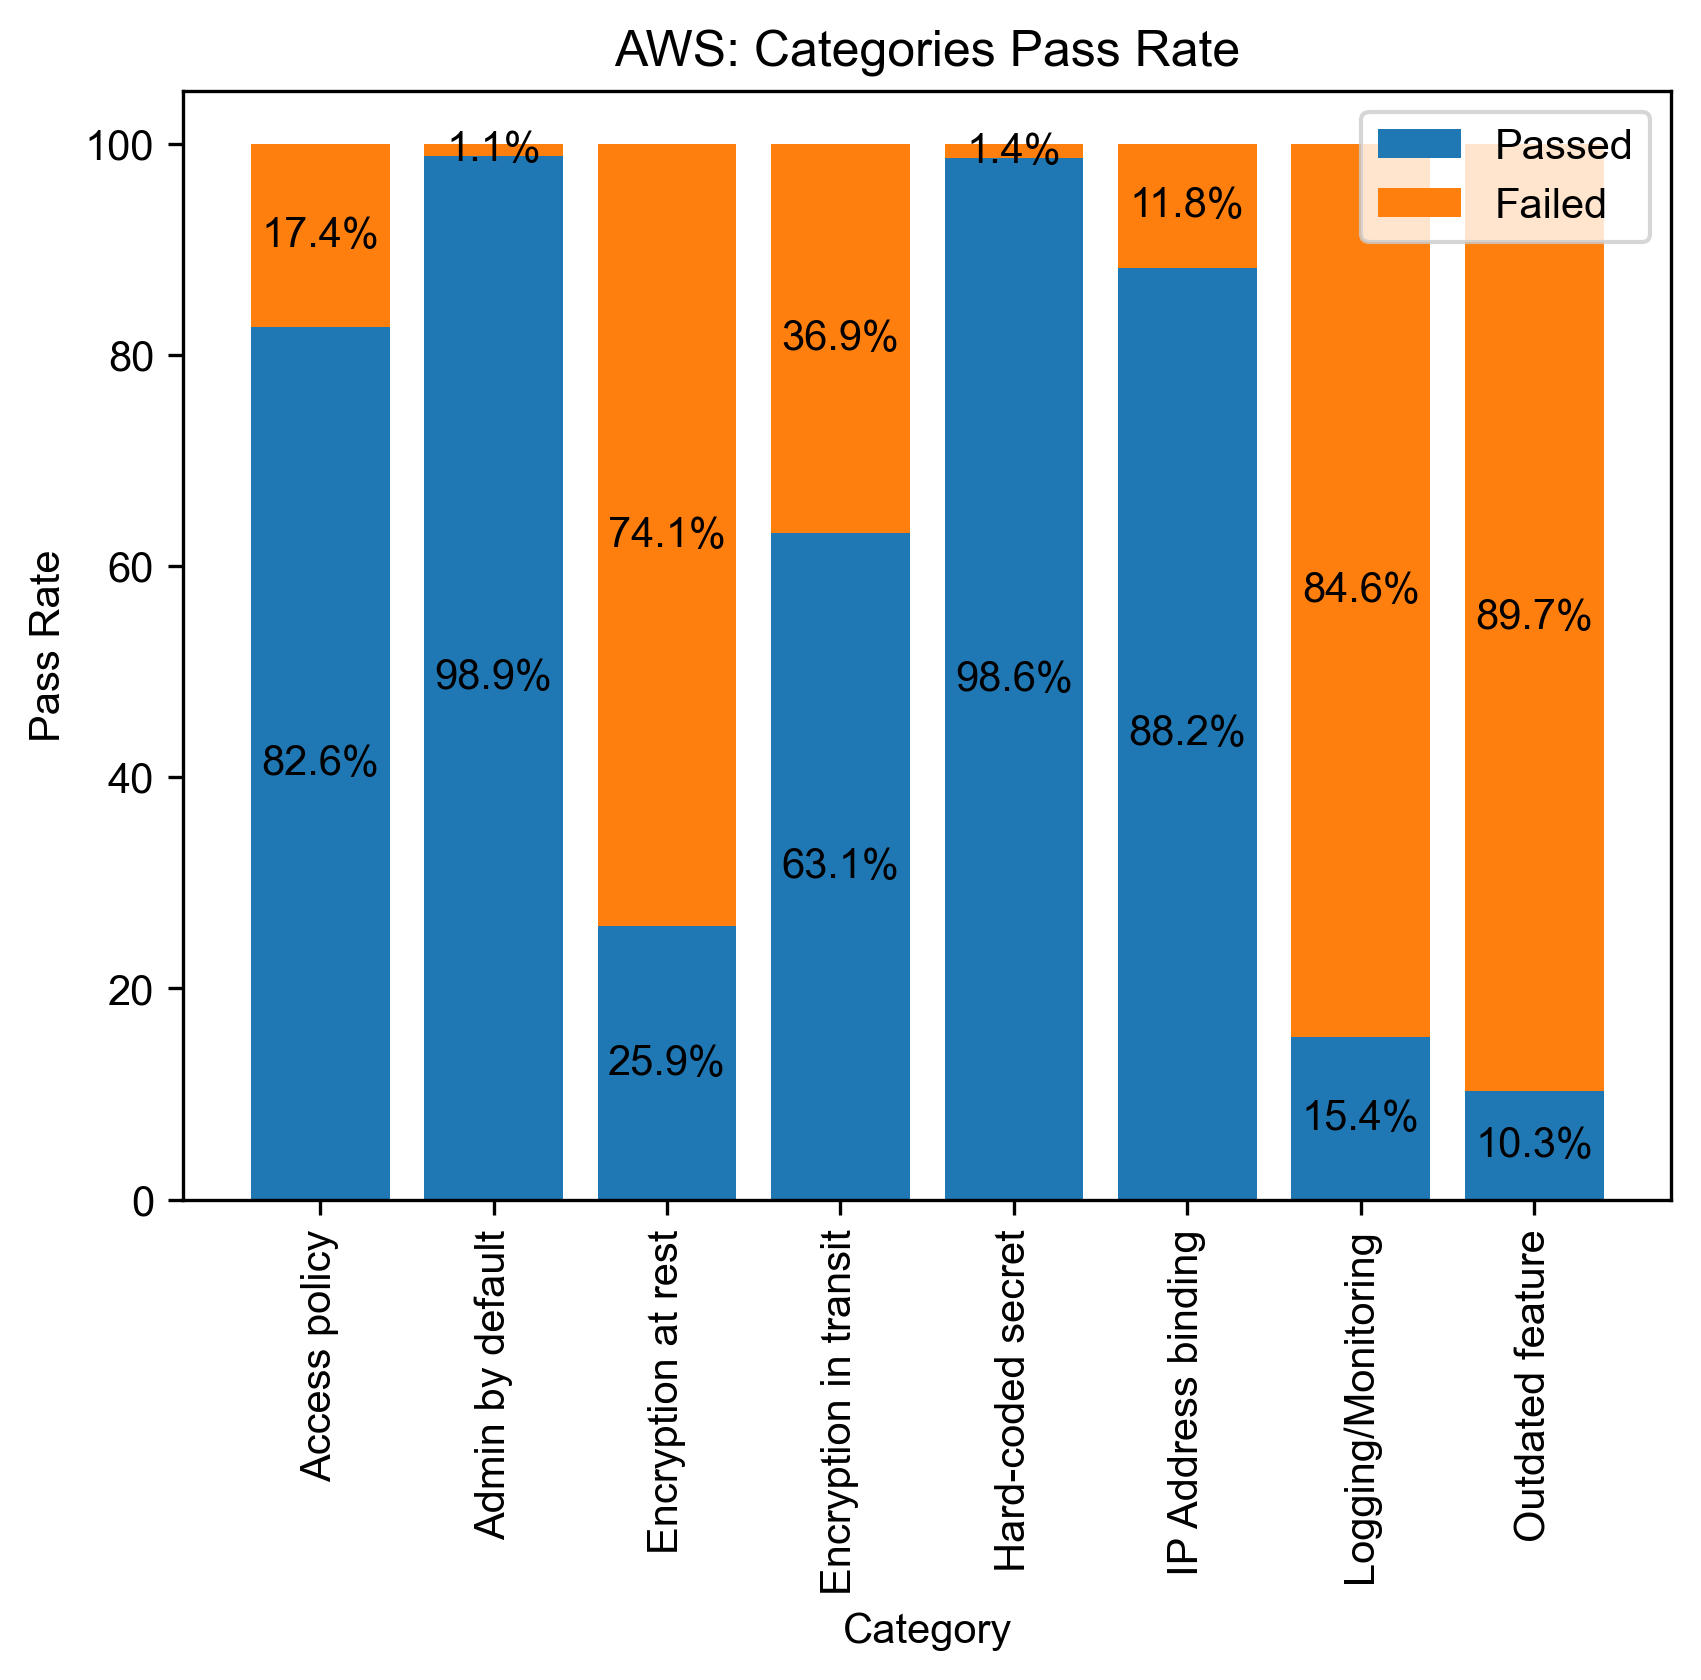

In [49]:
fig7, ax7 = plt.subplots()
x = sorted([*categories_rates.keys()])
y1 = [100*categories_rates[k] for k in x]
y2 = [100-k for k in y1]
bc1 = ax7.bar(x, y1)
bc2 = ax7.bar(x, y2, bottom=y1)
ax7.bar_label(bc1, labels=['{0:.1f}%'.format(e) for e in y1], label_type='center')
ax7.bar_label(bc2, labels=['{0:.1f}%'.format(e) for e in y2], label_type='center')
ax7.set(xlabel="Category", ylabel="Pass Rate", title="AWS: Categories Pass Rate")
ax7.legend(["Passed", "Failed"])
plt.xticks(rotation=90)
plt.show()

## RQ2/RQ3 : Best and Worst Pass/Fail Policies

In [50]:
policies_rate = {}
for policy in policies:
    if passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0) > 50:
        policies_rate[policy] = passed_count_dict.get(policy, 0) / (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0))

print("Averate Pass/Fail Rate: {}".format(np.average([*policies_rate.values()])))
        
sorted_policies_rates = sorted(policies_rate, key=policies_rate.get, reverse=True)
print("Best 5 Pass / Fail Rate Policies")
for policy in sorted_policies_rates[:6]:
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))
print("Worst 5 Pass / Fail Rate Policies")
for policy in reversed(sorted_policies_rates[-7:]):
    print("{} - {} - {}".format(policy, (passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)), policies_rate[policy]))

Averate Pass/Fail Rate: 0.5919208214924775
Best 5 Pass / Fail Rate Policies
CKV_AWS_251 - 54 - 1.0
CKV_AWS_60 - 1911 - 0.9994767137624281
CKV_AWS_61 - 1911 - 0.9994767137624281
CKV_AWS_46 - 660 - 0.9984848484848485
CKV_AWS_45 - 616 - 0.9983766233766234
CKV_AWS_227 - 243 - 0.9958847736625515
Worst 5 Pass / Fail Rate Policies
CKV2_AWS_12 - 440 - 0.006818181818181818
CKV_AWS_136 - 159 - 0.018867924528301886
CKV2_AWS_11 - 439 - 0.03416856492027335
CKV_AWS_79 - 963 - 0.04984423676012461
CKV_AWS_8 - 850 - 0.05058823529411765
CKV_AWS_119 - 161 - 0.055900621118012424
CKV_AWS_126 - 659 - 0.06069802731411229


Print Average number of test per category

In [51]:
policies_nb_runs = {}
for policy in policies:
    policies_nb_runs[policy] = passed_count_dict.get(policy, 0) + failed_count_dict.get(policy, 0)
mean_category_runs = {}
for policy in policies_nb_runs:
    mean_category_runs[categories.get(policy, "Uncategorized")] = mean_category_runs.get(categories.get(policy, "Uncategorized"), []) + [policies_nb_runs[policy]]

for category in mean_category_runs:
    mean_category_runs[category] = np.average(mean_category_runs[category])
print(mean_category_runs)

{'Admin by default': 1652.3333333333333, 'Encryption in transit': 114.4, 'Encryption at rest': 130.71428571428572, 'Access policy': 709.3103448275862, 'Logging/Monitoring': 256.6875, 'IP Address binding': 1063.8333333333333, 'Hard-coded secret': 1035.75, 'Outdated feature': 313.5}
